Let's first add some code that will let us use a CNN to get embeddings for our images.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 160MB/s]


Now let's load up our data, including embeddings and thumbnails. We don't have labels for our test data, so while we load up images and labels for the training and validation data, we only load up images for the test data.

In [2]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

ROOT = '/kaggle/input/dataset-of-fertile-and-infertile-chicken-eggs'
TEST_IMAGES = ROOT + '/test/images'
THUMBNAIL_SIZE = (128, 128)
TRAIN_IMAGES = ROOT + '/train/images'
TRAIN_LABELS = ROOT + '/train/labels'
VALID_IMAGES = ROOT + '/valid/images'
VALID_LABELS = ROOT + '/valid/labels'


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)

def label(filename: str, labels: str) -> int:
    label_file = labels + '/' + filename.replace('.jpg', '.txt')
    with open(file=label_file, mode='r') as input_fp:
        data = input_fp.read()
    return int(data.split()[0])

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

time_start = arrow.now()
train_df = pd.DataFrame(data=[pd.Series(data=[basename(item), embed(model=model, filename=item), png(filename=item)],
                                        index=['item', 'value', 'png']) for item in iglob(TRAIN_IMAGES + '/*.jpg')])
train_df['label'] = train_df['item'].apply(func=label, args=(TRAIN_LABELS, ))
valid_df = pd.DataFrame(data=[pd.Series(data=[basename(item), embed(model=model, filename=item), png(filename=item)],
                                        index=['item', 'value', 'png']) for item in iglob(VALID_IMAGES + '/*.jpg')])
valid_df['label'] = valid_df['item'].apply(func=label, args=(VALID_LABELS, ))
test_df = pd.DataFrame(data=[pd.Series(data=[basename(item), embed(model=model, filename=item), png(filename=item)],
                                        index=['item', 'value', 'png']) for item in iglob(TEST_IMAGES + '/*.jpg')])
print('done in {}'.format(arrow.now() - time_start))

done in 0:00:32.940731


How much data do we have?

In [3]:
len(train_df), len(test_df), len(valid_df)

(139, 20, 40)

In [4]:
df = pd.concat(objs=[train_df, valid_df])

In [5]:
import arrow
from umap import UMAP

time_start = arrow.now()
umap = UMAP(random_state=2024, verbose=False, n_jobs=1, low_memory=False, n_epochs=201)
df[['x', 'y']] = umap.fit_transform(X=df['value'].apply(func=pd.Series))
print('done with UMAP in {}'.format(arrow.now() - time_start))

done with UMAP in 0:00:09.957495


In [6]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)

<Axes: xlabel='x', ylabel='y'>

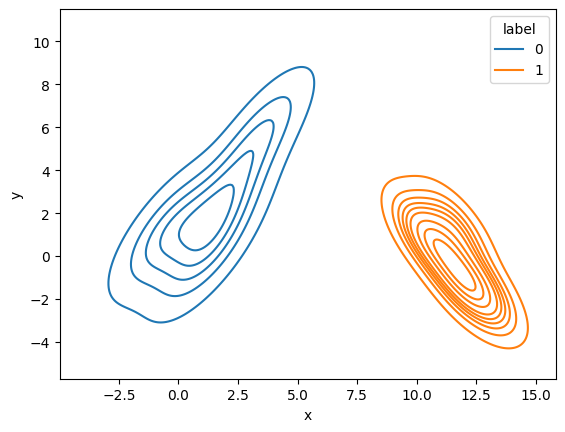

In [7]:
from seaborn import kdeplot

kdeplot(data=df, x='x', y='y', hue='label', bw_method=0.9)

<Axes: xlabel='x', ylabel='y'>

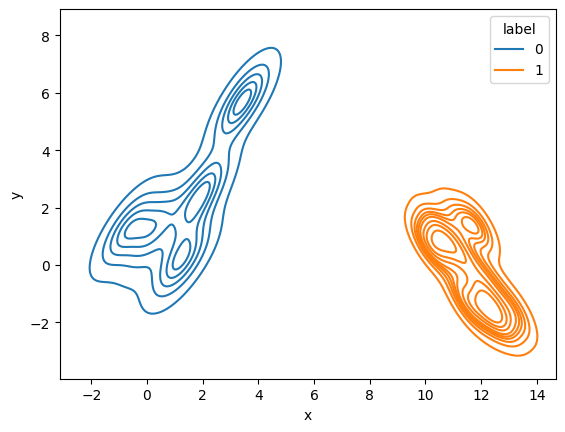

In [8]:
kdeplot(data=df, x='x', y='y', hue='label', bw_method='scott')

In [9]:
df[df['label'] == 0]['value'].apply(func=pd.Series).shape, df[df['label'] == 1]['value'].apply(func=pd.Series).shape 

((90, 2048), (89, 2048))

In [10]:
from scipy.stats import gaussian_kde

k0 = gaussian_kde(dataset=df[df['label'] == 0]['value'].apply(func=pd.Series), bw_method=0.9)
k1 = gaussian_kde(dataset=df[df['label'] == 1]['value'].apply(func=pd.Series), bw_method='scott')

In [11]:
k0.factor, k1.factor

(0.9, 0.9212856393283106)

In [12]:
gaussian_kde(dataset=df[df['label'] == 0]['value'].apply(func=pd.Series), bw_method='scott').factor

0.922089519009156

In [13]:
gaussian_kde(dataset=df[df['label'] == 0]['value'].apply(func=pd.Series), bw_method='silverman').factor

0.8918393269327378